# LSTM Camels-ESP

In [1]:
! pip install neuralhydrology

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 3.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 12.5 MB/s eta 0:00:00


In [2]:
import pickle
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import torch

from neuralhydrology.utils.config import Config
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/TFM/notebook/models/
from model_utils import *
%cd ./CAMELS-ESP/

/content/drive/MyDrive/TFM/notebook/models
/content/drive/MyDrive/TFM/notebook/models/CAMELS-ESP


### Configuración

In [8]:
# cargar archivo de configuración
config_file = Path('config2_clipNone.yml')
cfg = Config(config_file)

target = cfg.target_variables[0]

print(cfg.experiment_name)
print('hidden size:', cfg.hidden_size, sep='\t')
print('batch size:', cfg.batch_size, sep='\t')
print('dropout:', cfg.output_dropout, sep='\t')
print('clip gradients:', cfg.clip_gradient_norm, sep='\t')

CAMELS-ESP2_clipNone
hidden size:	64
batch size:	256
dropout:	0.4
clip gradients:	None


### Entrenamiento

In [9]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    start_run(config_file=config_file)

# fall back to CPU-only mode
else:
    start_run(config_file=config_file, gpu=-1)

# Validation: 100%|██████████| 53/53 [00:03<00:00, 13.36it/s]


### Simulación

In [10]:
# 128 neuronas en la capa oculta
run_dir = Path(f'runs/{cfg.experiment_name}_1109_183744')

In [11]:
# periodo de entrenamiento
eval_run(run_dir=run_dir, period='train', gpu=0)

# Evaluation: 100%|██████████| 161/161 [01:00<00:00,  2.66it/s]


In [12]:
# periodo de validación
eval_run(run_dir=run_dir, period='validation', gpu=0)

# Validation: 100%|██████████| 53/53 [00:20<00:00,  2.56it/s]


In [13]:
# periodo de evaluación
eval_run(run_dir=run_dir, period='test', gpu=0)

# Evaluation: 100%|██████████| 53/53 [00:23<00:00,  2.22it/s]


## Resultados

In [14]:
results = {}
metrics = pd.DataFrame()
for period in ['train', 'validation', 'test']:
    # importar resultados
    results_period, metrics_period = get_results(run_dir, period, epoch=cfg.epochs)
    metrics_period.columns = [period]
    results[period] = results_period
    metrics = pd.concat((metrics, metrics_period), axis=1)

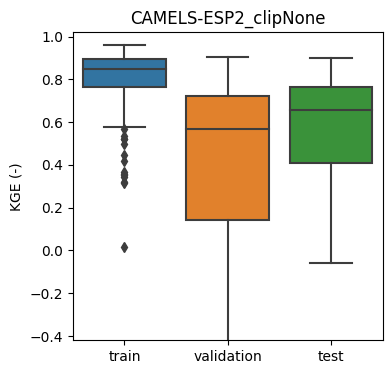

In [15]:
# diagramas de caja del rendimiento (KGE)
fig, ax = plt.subplots(figsize=(4, 4))
sns.boxplot(metrics, ax=ax)
ax.set(title=cfg.experiment_name, ylabel=f'{cfg.metrics[0]} (-)', ylim=(-.42, 1.02));

plt.savefig(run_dir / f'{cfg.metrics[0]}.jpg', dpi=300, bbox_inches='tight')

In [16]:
for period, dct in results.items():
    path = run_dir / 'hidrogramas' / period
    if path.exists() is False:
        path.mkdir(parents=True)
    plot_results(dct, period, target, save=path)

Output hidden; open in https://colab.research.google.com to view.

In [18]:
# exportar rendimiento
metrics.to_csv(str(run_dir / f'{cfg.metrics[0]}.csv'), float_format='%.3f')